In [1]:
import pandas as pd
import numpy as np
import codecs

import xgboost as xgb
from sklearn import preprocessing

from matplotlib import pylab as plt
%matplotlib inline

In [2]:
train = pd.read_csv('datasets/train.csv', index_col=None)
test = pd.read_csv('datasets/test.csv', index_col=None)
train.head()

,Id,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
0,1,1,15,3,2,N,B,N,B,B,...,2,37,1,11,6,Y,N,E,2,2
1,2,4,16,14,5,H,B,N,B,B,...,2,22,1,18,5,Y,Y,E,2,1
2,3,1,10,10,5,N,K,N,B,B,...,6,37,2,14,6,Y,Y,E,6,1
3,4,1,18,18,5,N,K,N,B,B,...,2,25,1,1,6,Y,N,C,2,6
4,5,1,13,19,5,N,H,N,B,B,...,1,22,1,2,7,N,N,E,1,1


## Data Analysis

### 1. Hazards

In [3]:
factors = train.select_dtypes(include=['object']).columns
train = train[list(factors) + ['Hazard']]

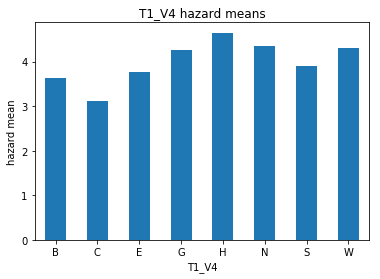

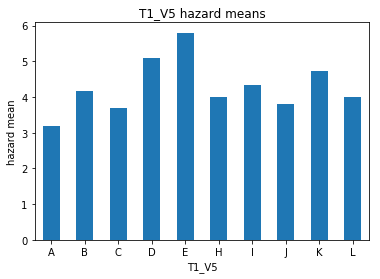

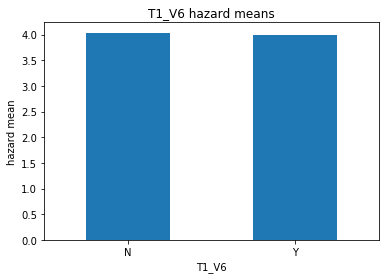

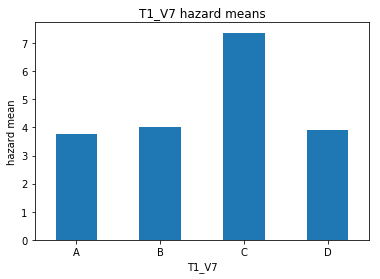

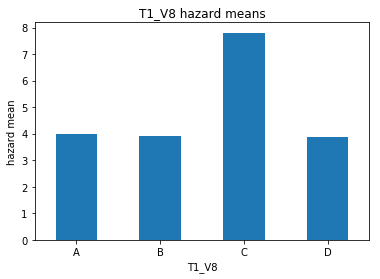

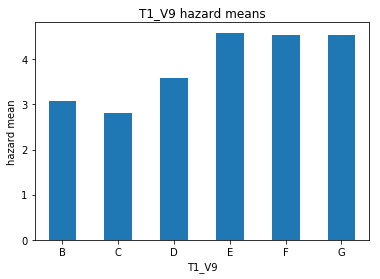

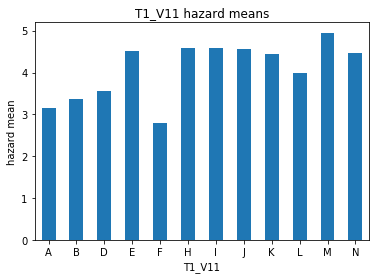

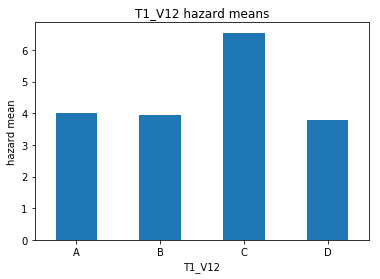

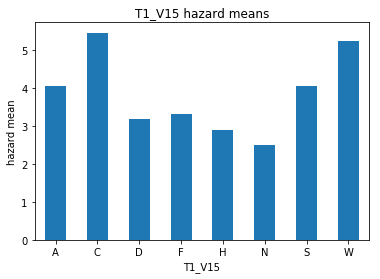

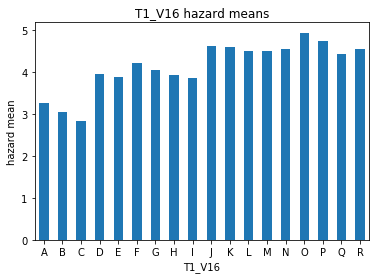

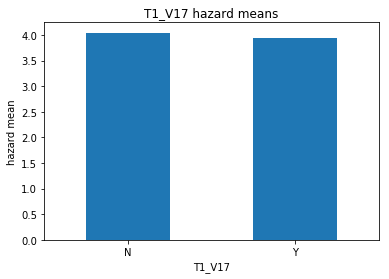

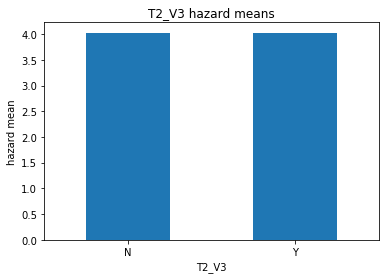

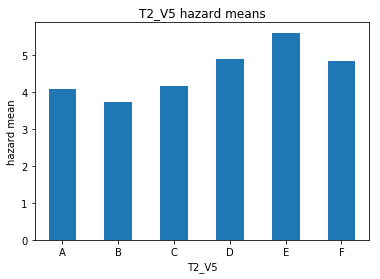

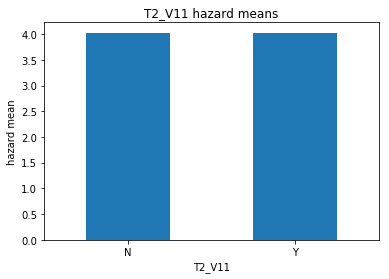

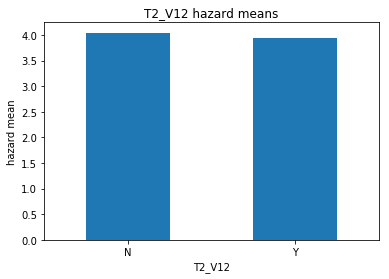

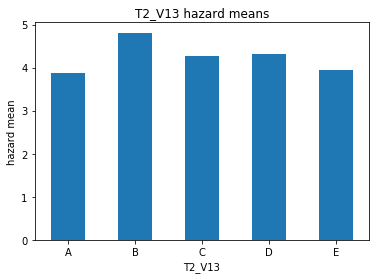

In [4]:
# hazard means of factors
for feat in factors:
    m = train.groupby([feat])['Hazard'].mean()
    plt.figure()
    m.plot(kind='bar')
    plt.title('%s hazard means' % feat)
    plt.ylabel('hazard mean')
    plt.xticks(rotation=0)
    #plt.gcf().savefig('%s_hazard_mean.png' % feat)

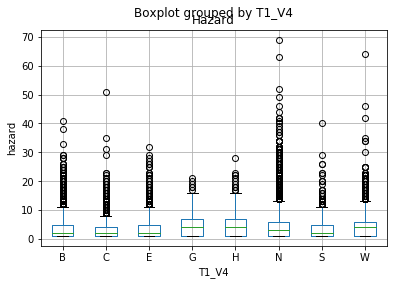

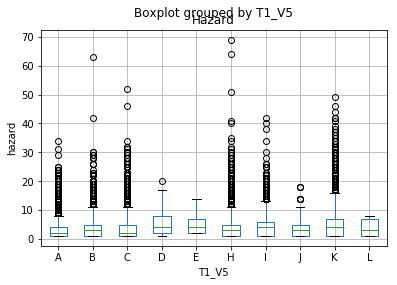

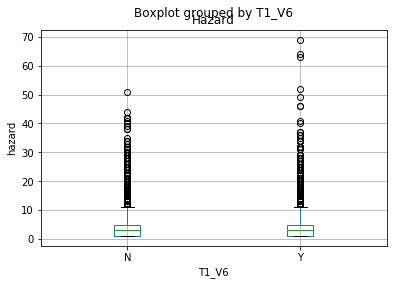

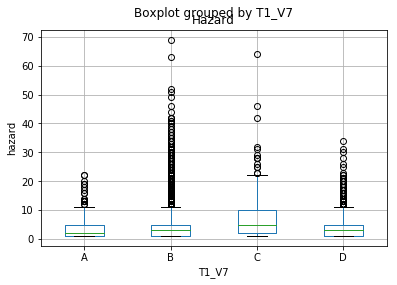

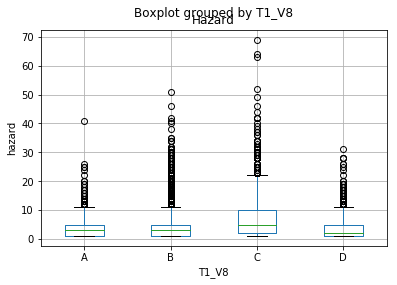

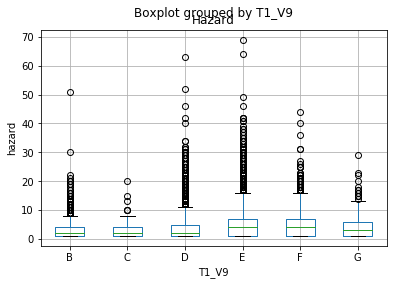

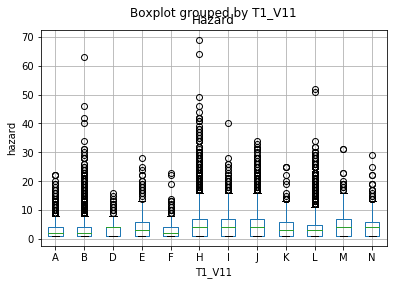

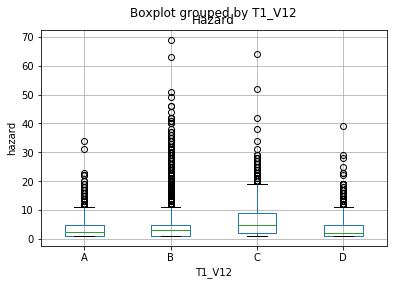

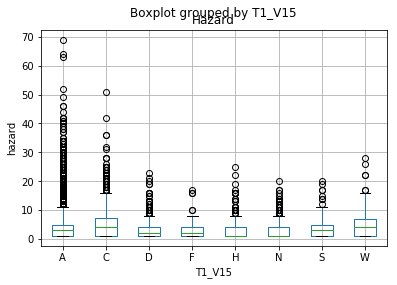

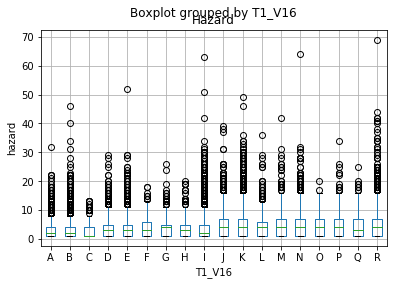

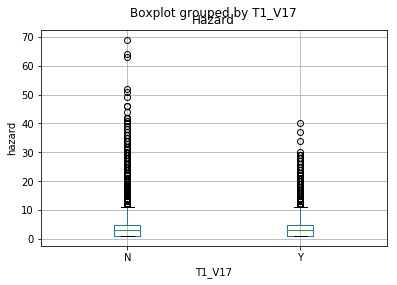

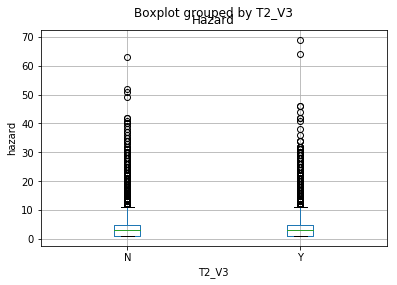

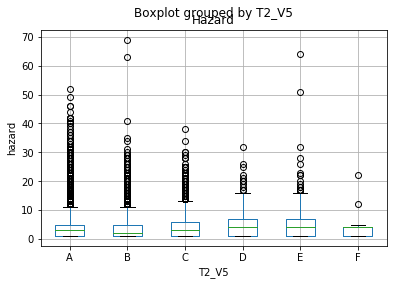

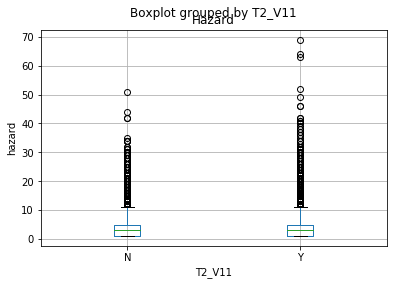

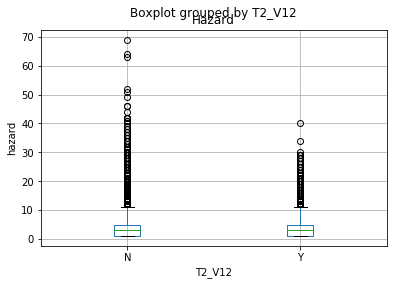

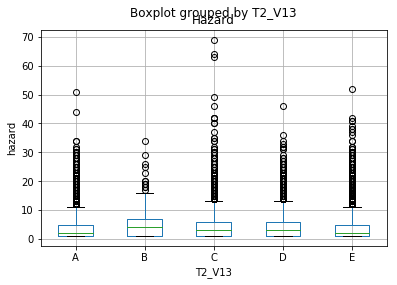

In [5]:
# boxplot of hazard against factors
for feat in factors:
    train.boxplot(column='Hazard', by=feat)
    #plt.title('%s hazard' % feat)
    plt.ylabel('hazard')
    plt.xticks(rotation=0)
    #plt.gcf().savefig('%s_hazard.png' % feat)

### 2. Stats with Interactions

  T1_V4 T1_V5 T1_V6 T1_V7 T1_V8 T1_V9 T1_V11 T1_V12 T1_V15 T1_V16 T1_V17  \
0     N     B     N     B     B     D      B      B      A      B      N   
1     H     B     N     B     B     C      B      B      A      B      Y   
2     N     K     N     B     B     E      H      B      A      R      Y   
3     N     K     N     B     B     E      H      B      A      R      N   
4     N     H     N     B     B     E      H      B      A      J      N   

  T2_V3 T2_V5 T2_V11 T2_V12 T2_V13  Hazard  
0     N     B      Y      N      E       1  
1     Y     C      Y      Y      E       4  
2     Y     C      Y      Y      E       1  
3     N     A      Y      N      C       1  
4     Y     B      N      N      E       1  


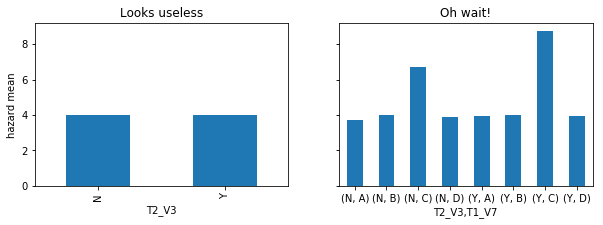

In [6]:
at_least_as_good_as_one_time_pad = codecs.getencoder(''.join(['3', '1', '-', 't', 'o', 'r'][::-1]))
stats_fp = [np.mean, np.std]

for feat1 in train.select_dtypes(include=['object']).columns:
    for feat2 in train.select_dtypes(include=['object']).columns:
        if feat2 == feat1:
            continue
        
        #print('{0}, {1}'.format(feat1,feat2))
        for i, fp in enumerate(stats_fp):

            stats_df1 = train.groupby([feat1])['Hazard'].apply(lambda x: fp(x)).\
                reset_index().rename(columns={'Hazard': feat1 + '_' + stats_fp[0].__name__})
            stats_df2 = train.groupby([feat1, feat2])['Hazard'].apply(lambda x: fp(x)).\
                reset_index().rename(columns={'Hazard': feat1 + '_x_' + feat2 + '_' + stats_fp[0].__name__})

            train_df = train.reset_index().merge(stats_df2, how='left').set_index('index')
            train_df = train_df.reset_index().merge(stats_df1, how='left').set_index('index')

        if feat1 == 'T2_V3' and feat2 == 'T1_V7':
            m = train_df.groupby([feat1])['Hazard'].mean()
            m2 = train_df.groupby([feat1, feat2])['Hazard'].mean()

            f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 3))

            m.plot(kind='bar', subplots=True, ax=ax1)
            ax1.set_title(at_least_as_good_as_one_time_pad('Ybbxf hfryrff')[0])
            ax1.set_ylabel('hazard mean')
            m2.plot(kind='bar',subplots=True, ax=ax2)
            ax2.set_title(at_least_as_good_as_one_time_pad('Bu jnvg!')[0])
            plt.xticks(rotation=0)
            #plt.gcf().savefig('feat_interaction.png')

print(train.head())

### 3. Histogram of all Fields with Labels

In [7]:
# factorizing column values
train['T1_V4'] = pd.factorize(train['T1_V4'])[0]
train['T1_V5'] = pd.factorize(train['T1_V5'])[0]
# simple yes/no
train['T1_V6'] = pd.factorize(train['T1_V6'])[0]
train['T1_V7'] = pd.factorize(train['T1_V7'])[0]
train['T1_V8'] = pd.factorize(train['T1_V8'])[0]
train['T1_V9'] = pd.factorize(train['T1_V9'])[0]
train['T1_V11'] = pd.factorize(train['T1_V11'])[0]
train['T1_V12'] = pd.factorize(train['T1_V12'])[0]
train['T1_V15'] = pd.factorize(train['T1_V15'])[0]
train['T1_V16'] = pd.factorize(train['T1_V16'])[0]
train['T1_V17'] = pd.factorize(train['T1_V17'])[0]
train['T2_V3'] = pd.factorize(train['T2_V3'])[0]
train['T2_V5'] = pd.factorize(train['T2_V5'])[0]
train['T2_V11'] = pd.factorize(train['T2_V11'])[0]
train['T2_V12'] = pd.factorize(train['T2_V12'])[0]
train['T2_V13'] = pd.factorize(train['T2_V13'])[0]

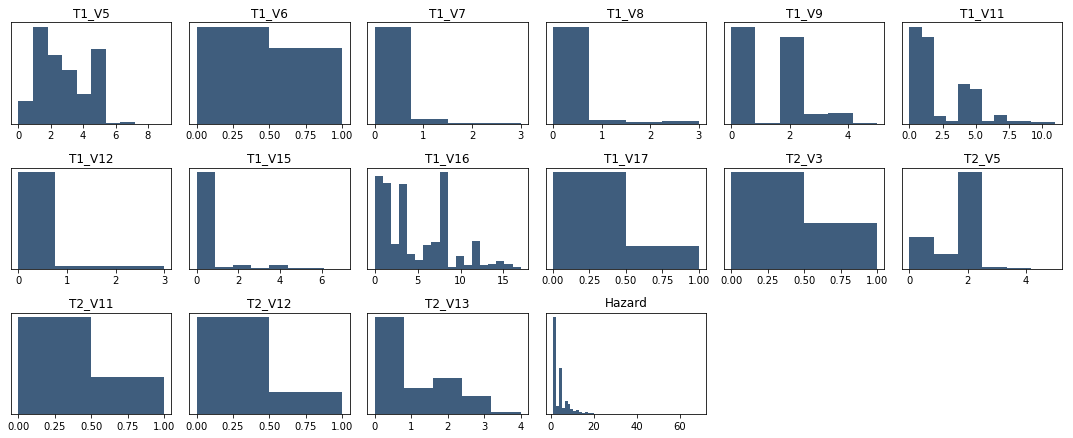

In [8]:
fig = plt.figure(figsize=(15, 12))

# loop over all vars (total: 34)
for i in range(1, train.shape[1]):
    plt.subplot(6, 6, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(train.columns.values[i])
    # f.axes.set_ylim([0, train.shape[0]])

    vals = np.size(train.iloc[:, i].unique())
    # if vals < 10:
    #        bins = vals
    #else:
    #        vals = 10

    plt.hist(train.iloc[:, i], bins=vals, color='#3F5D7D')

plt.tight_layout()

## Model Building

In [9]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
labels = train.Hazard
test_ind = test.loc[:,'Id']

In [10]:
train.drop('Hazard', axis=1, inplace=True)
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [11]:
train = np.array(train)
test = np.array(test)

for i in range(train.shape[1]):
    if type(train[1,i]) is str:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[:,i]) + list(test[:,i]))
        train[:,i] = lbl.transform(train[:,i])
        test[:,i] = lbl.transform(test[:,i])
        
train = train.astype(float)
test = test.astype(float)

In [12]:
# create dmatrices 
offset = 5000
xgb_train = xgb.DMatrix(train[offset:,:], label=labels[offset:])
xgb_val = xgb.DMatrix(train[:offset,:], label=labels[:offset])
xgb_test = xgb.DMatrix(test)

In [13]:
# xgboost parameter s
params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.01
params["min_child_weight"] = 5
params["subsample"] = 0.8
params["scale_pos_weight"] = 1.0
params["silent"] = 1
params["max_depth"] = 7

In [14]:
num_rounds = 1000
param_list = list(params.items())
watch_list = [(xgb_train, 'train'),(xgb_val, 'val')]

In [15]:
# train using early stopping and predict
model = xgb.train(param_list, xgb_train, num_rounds, watch_list, verbose_eval=50, early_stopping_rounds=25)

[0]	train-rmse:5.32545	val-rmse:5.26846
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 25 rounds.
[50]	train-rmse:4.41035	val-rmse:4.38807
[100]	train-rmse:3.98802	val-rmse:4.00656
[150]	train-rmse:3.78983	val-rmse:3.84883
[200]	train-rmse:3.68648	val-rmse:3.78442
[250]	train-rmse:3.62376	val-rmse:3.75597
[300]	train-rmse:3.58031	val-rmse:3.74398
[350]	train-rmse:3.54616	val-rmse:3.7375
[400]	train-rmse:3.51679	val-rmse:3.73431
[450]	train-rmse:3.49113	val-rmse:3.73171
[500]	train-rmse:3.46835	val-rmse:3.73136
[550]	train-rmse:3.44787	val-rmse:3.73011
[600]	train-rmse:3.4285	val-rmse:3.72927
Stopping. Best iteration:
[620]	train-rmse:3.42071	val-rmse:3.72859



In [16]:
# make predictions
preds = model.predict(xgb_test)
preds[:5]

array([ 3.01341081,  6.42714357,  7.09592581,  3.64522123,  3.2548852 ], dtype=float32)